# Food Delivery: Machine Learning Model
Tsyr Rau Chen, Arailym Duisengali, Sheikh Noohery, Lo Ying Wu, and Kuan Rong Yang

## SQL

In [ ]:
# basic mports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
conn = sqlite3.connect("/content/food_delivery.db")

In [ ]:
# extract features
# sql query
sql_query = """
SELECT
    d.tip_amount,
    (julianday(d.dropoff_time) - julianday(d.pickup_time)) * 24 * 60 AS duration_minutes,
    d.distance_km,
    r.city
FROM deliveries d
JOIN orders o ON d.order_id = o.order_id
JOIN restaurants r ON o.restaurant_id = r.restaurant_id
WHERE d.pickup_time IS NOT NULL AND d.dropoff_time IS NOT NULL
"""

# create database with the query results
df = pd.read_sql_query(sql_query, conn)
conn.close()

print(df.head())

   tip_amount  duration_minutes  distance_km           city
0       11.22              23.0         3.03         Austin
1        9.80              13.0         8.39       New York
2        3.33              18.0         4.06         Austin
3        0.32              11.0         2.66         Austin
4       25.89              14.0         4.52  San Francisco


In [ ]:
# export to csv
pd.DataFrame(df).to_csv("food_delivery.csv", index=False)

## Exploratory Graphs

In [ ]:
# data cleaning
# drom missing values
df = df.dropna()

# convert to numeric types
df["tip_amount"] = pd.to_numeric(df["tip_amount"], errors="coerce")
df["duration_minutes"] = pd.to_numeric(df["duration_minutes"], errors="coerce")
df["distance_km"] = pd.to_numeric(df["distance_km"], errors="coerce")

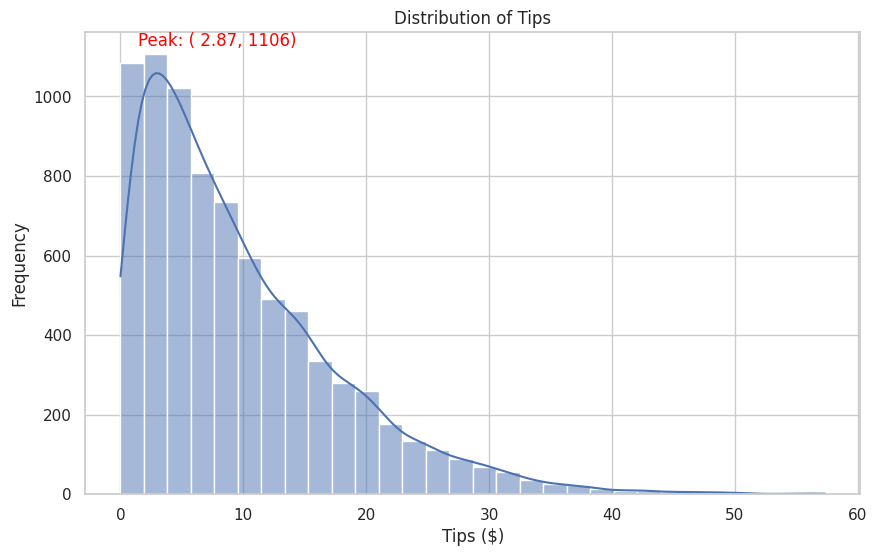

In [ ]:
# set a graph style
plt.rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid")

# compute histogram data to get the tallest frequency
counts, bin_edges = np.histogram(df["tip_amount"], bins=30)

# tallest bar
max_count = counts.max()
max_index = counts.argmax()
max_bin_center = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2

# histogram of tips
sns.histplot(df["tip_amount"], bins=30, kde=True)

# highest frequency
plt.text(max_bin_center + 5, max_count + 20,
         f"Peak: ({max_bin_center: .2f}, {max_count})",
         ha = 'center', color = 'red')

plt.title("Distribution of Tips")
plt.xlabel("Tips ($)")
plt.ylabel("Frequency")
plt.show()

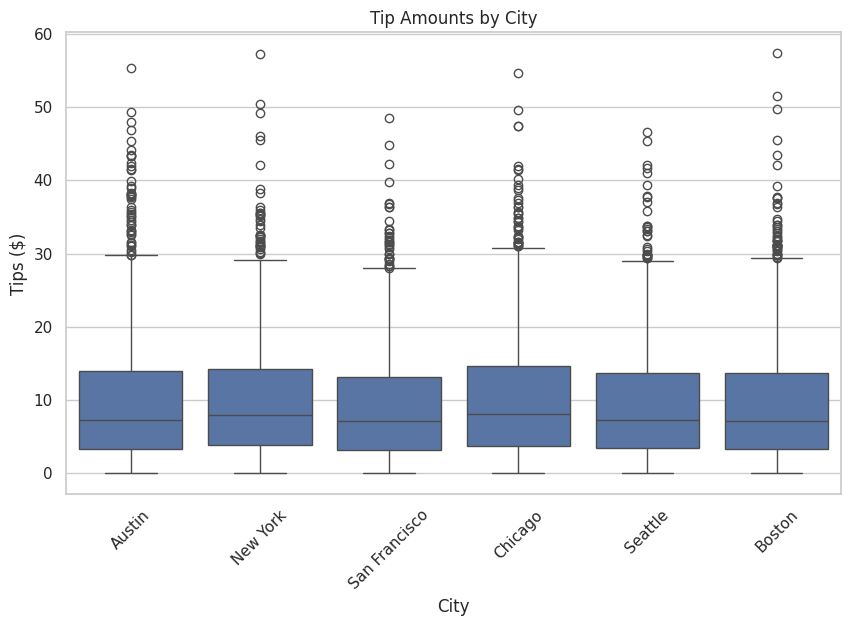

In [ ]:
# boxplot of tips by city
sns.boxplot(x="city", y="tip_amount", data=df)
plt.title("Tip Amounts by City")
plt.xlabel("City")
plt.ylabel("Tips ($)")
plt.xticks(rotation=45)
plt.show()

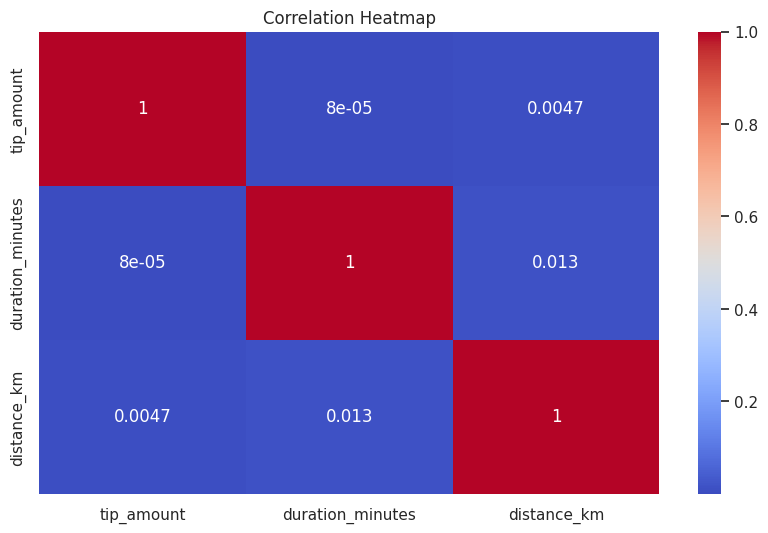

In [ ]:
# correlation heatmap
sns.heatmap(df[["tip_amount","duration_minutes","distance_km"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Machine Learning

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# separate features and target
X = df[['duration_minutes', 'distance_km', 'city']]
y = df['tip_amount']

# one-hot encode city
encoder = OneHotEncoder(sparse_output=False)
city_encoded = encoder.fit_transform(X[['city']])
city_cols = encoder.get_feature_names_out(['city'])

# build final feature DataFrame
import numpy as np
X_final = pd.concat([
    X.drop(columns=['city']).reset_index(drop=True),
    pd.DataFrame(city_encoded, columns=city_cols)
], axis=1)

In [ ]:
# training and testing split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

### Baseline Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred_lr = lr.predict(X_test)

# model metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression MAE: {mae_lr:.4f}")



Linear Regression RMSE: 7.9940
Linear Regression MAE: 6.2162


In [ ]:
# polynomial Regression (degree 2)
# scale features before polynomial
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# polynomial features
poly_2d = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_2d = poly_2d.fit_transform(X_train_scaled)
X_test_poly_2d = poly_2d.transform(X_test_scaled)

# fit polynomial regression
lr_poly_2d = LinearRegression()
lr_poly_2d.fit(X_train_poly_2d, y_train)

# predict
y_pred_poly_2d = lr_poly_2d.predict(X_test_poly_2d)

# model metrics
rmse_poly_2d = np.sqrt(mean_squared_error(y_test, y_pred_poly_2d))
mae_poly_2d = mean_absolute_error(y_test, y_pred_poly_2d)

print(f"Polynomial Regression RMSE: {rmse_poly_2d:.4f}")
print(f"Polynomial Regression MAE: {mae_poly_2d:.4f}")

Polynomial Regression RMSE: 7.9919
Polynomial Regression MAE: 6.2164


In [ ]:
# polynomial Regression (degree 3)
# polynomial features
poly_3d = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_3d = poly_3d.fit_transform(X_train_scaled)
X_test_poly_3d = poly_3d.transform(X_test_scaled)

# fit polynomial regression
lr_poly_3d = LinearRegression()
lr_poly_3d.fit(X_train_poly_3d, y_train)

# predict
y_pred_poly_3d = lr_poly_3d.predict(X_test_poly_3d)

# model metrics
rmse_poly_3d = np.sqrt(mean_squared_error(y_test, y_pred_poly_3d))
mae_poly_3d = mean_absolute_error(y_test, y_pred_poly_3d)

print(f"Polynomial Regression RMSE: {rmse_poly_3d:.4f}")
print(f"Polynomial Regression MAE: {mae_poly_3d:.4f}")

Polynomial Regression RMSE: 8.0005
Polynomial Regression MAE: 6.2100


In [ ]:
# polynomial Regression (degree 4)
# polynomial features
poly_4d = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly_4d = poly_4d.fit_transform(X_train_scaled)
X_test_poly_4d = poly_4d.transform(X_test_scaled)

# fit polynomial regression
lr_poly_4d = LinearRegression()
lr_poly_4d.fit(X_train_poly_4d, y_train)

# predict
y_pred_poly_4d = lr_poly_4d.predict(X_test_poly_4d)

# model metrics
rmse_poly_4d = np.sqrt(mean_squared_error(y_test, y_pred_poly_4d))
mae_poly_4d = mean_absolute_error(y_test, y_pred_poly_4d)

print(f"Polynomial Regression RMSE: {rmse_poly_4d:.4f}")
print(f"Polynomial Regression MAE: {mae_poly_4d:.4f}")

Polynomial Regression RMSE: 8.0049
Polynomial Regression MAE: 6.2077


### Advance Model

In [ ]:
# random forest model
from sklearn.ensemble import RandomForestRegressor

# random forest features
rf = RandomForestRegressor(
    n_estimators=1000,      # number of trees
    max_depth=None,
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# fit random forest model
rf.fit(X_train, y_train)

# predict
y_pred_rf = rf.predict(X_test)

# model metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest RMSE: 8.8464
Random Forest MAE: 6.8324


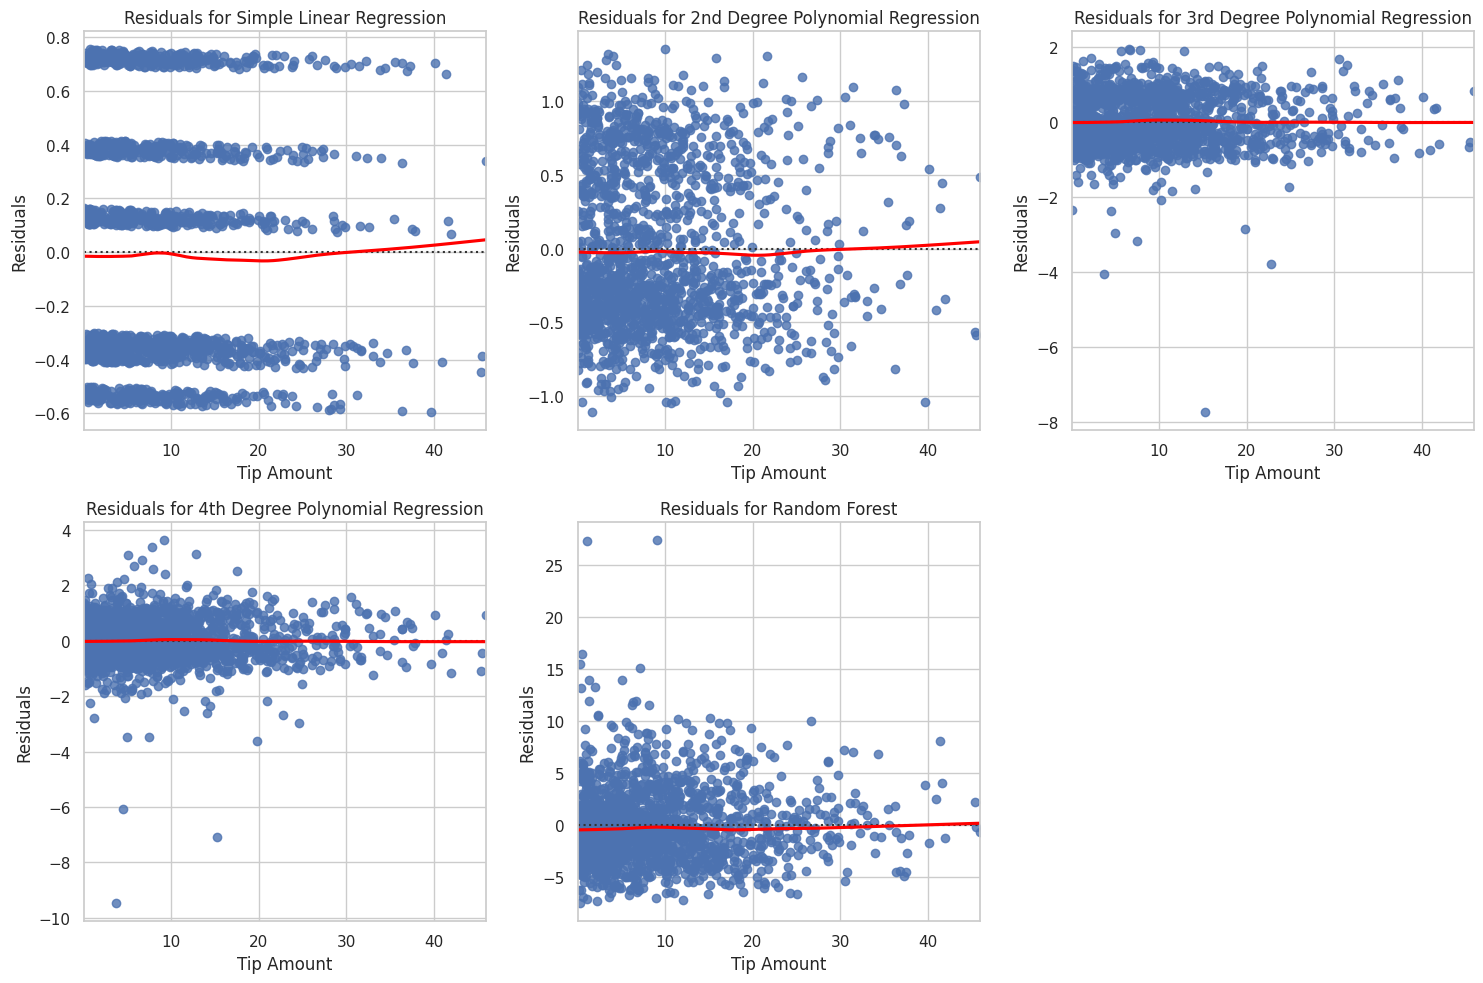

In [ ]:
# creating residual charts of the models
# grid for multiple charts
fig, axes = plt.subplots(2,3, figsize=(15,10))

# residuals for simple linear regression
sns.residplot(x=y_test, y=y_pred_lr, lowess=True, ax = axes[0,0],
              line_kws={'color':'red'})
axes[0,0].set_title("Residuals for Simple Linear Regression")
axes[0,0].set_xlabel("Tip Amount")
axes[0,0].set_ylabel("Residuals")

# residuals for 2nd degree polynomial regression
sns.residplot(x=y_test, y=y_pred_poly_2d, lowess=True, ax = axes[0,1],
              line_kws={'color':'red'})
axes[0,1].set_title("Residuals for 2nd Degree Polynomial Regression")
axes[0,1].set_xlabel("Tip Amount")
axes[0,1].set_ylabel("Residuals")

# residuals for 3rd degree polynomial regression
sns.residplot(x=y_test, y=y_pred_poly_3d, lowess=True, ax = axes[0,2],
              line_kws={'color':'red'})
axes[0,2].set_title("Residuals for 3rd Degree Polynomial Regression")
axes[0,2].set_xlabel("Tip Amount")
axes[0,2].set_ylabel("Residuals")

# residuals for 4th degree polynomial regression
sns.residplot(x=y_test, y=y_pred_poly_4d, lowess=True, ax = axes[1,0],
              line_kws={'color':'red'})
axes[1,0].set_title("Residuals for 4th Degree Polynomial Regression")
axes[1,0].set_xlabel("Tip Amount")
axes[1,0].set_ylabel("Residuals")

# residuals for random forest
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, ax = axes[1,1],
              line_kws={'color':'red'})
axes[1,1].set_title("Residuals for Random Forest")
axes[1,1].set_xlabel("Tip Amount")
axes[1,1].set_ylabel("Residuals")

axes[1,2].axis("off")

plt.tight_layout()
plt.show()


### Comparison

In [ ]:
# creating a df to comapre the rmse and mae scores
metrics = {
    "Linear": (rmse_lr, mae_lr),
    "Poly-2": (rmse_poly_2d, mae_poly_2d),
    "Poly-3": (rmse_poly_3d, mae_poly_3d),
    "Poly-4": (rmse_poly_4d, mae_poly_4d),
    "Random Forest": (rmse_rf, mae_rf),
}

metrics_df = pd.DataFrame(metrics, index=["RMSE", "MAE"]).T

In [ ]:
# best by rmse
print(metrics_df.sort_values(by="RMSE", ascending=True))

                   RMSE       MAE
Poly-2         7.991874  6.216402
Linear         7.994030  6.216206
Poly-3         8.000544  6.210023
Poly-4         8.004860  6.207737
Random Forest  8.846353  6.832367


In [ ]:
# best by mae
print(metrics_df.sort_values(by="MAE", ascending=True))

                   RMSE       MAE
Poly-4         8.004860  6.207737
Poly-3         8.000544  6.210023
Linear         7.994030  6.216206
Poly-2         7.991874  6.216402
Random Forest  8.846353  6.832367
